In [1]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math
import os

def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    return df_master

def species_plot(df):
    df = df.replace("__ribosome", "free ribosomes")
    df = df.replace("TTT_charged", "Rare tRNA")
    df = df.replace("TTT_uncharged", "uncharged tRNA")
    df = df.replace("ATA_charged", "Preferred tRNA")
    df_fil = df[(df.species == "Preferred tRNA") | (df.species == "free ribosomes") | (df.species == "Rare tRNA")]
    g = sns.lineplot(x="time", y="protein", units="seed", hue="species", estimator=None, data=df_fil)
    g.get_legend().set_title(None)

In [2]:
from trnasimtools.serialize import SerializeTwoCodonSingleTranscript

In [3]:
from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def get_average_protein(path_pref, time, max_seed, get_range=False):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    # get average species counts for all trials
    df_master = df_master.groupby(["time", "species"])["protein"].mean().reset_index() 
    if time not in df_master["time"].values:
        time = take_closest(df_master["time"].values, time)
    if not get_range:
        df_master = df_master[(df_master.time == time)] 
    else:
        df_master = df_master[(df_master.time >= time - 100)]
        df_master["TTT_ss"] = df_master[(df_master.species == "TTT_charged")]["protein"].mean()
        df_master["ATA_ss"] = df_master[(df_master.species == "ATA_charged")]["protein"].mean()
        df_master["rib_ss"] = df_master[(df_master.species == "__ribosome")]["protein"].mean()
        df_master = df_master[(df_master.time == time)]
    df_master = df_master.replace("__ribosome", "ribosomes")
    return df_master

In [13]:
rcParams['figure.figsize'] = [10, 5]

In [9]:
date = "may-3-2022"

In [15]:
date = "nov-20-2023"

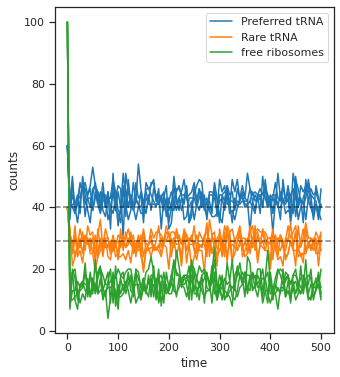

In [94]:
rcParams['figure.figsize'] = [5, 6]
df_master = read_sim("../output/may-3-2022/two_codon_single_transcript_0.4_0.6_0.4_0.6_100_100_100_100000.0_100.0_100.0", 1, 5, 1) #should be "one codon"
species_plot(df_master)
#ribosome_plot(df_master)
plt.ylabel("counts")
plt.gca().axhline(29, ls='--', color="black", alpha=0.5)
plt.gca().axhline(40, ls='--', color="black", alpha=0.5)

In [5]:
def binding_rate_conv(rate, N):
    AVOGADRO = 6.02214076e23
    VOLUME = 8e-16
    return rate / (AVOGADRO * VOLUME) * N

In [96]:
print(binding_rate_conv(RBS_STRENGTH, TS_COPY))

0.020756738339673085


In [6]:
def analytical_trna(charging_rate, TOTAL_TRNA, codon):
    AVOGADRO = 6.02214076e23
    VOLUME = 8e-16
    binding_rate = RBS_STRENGTH / (AVOGADRO * VOLUME) * 200
    u = ((charging_rate * TOTAL_TRNA * SPEED)/(LEN)) - (RB_COPY * codon * binding_rate * TS_COPY * SPEED) - (charging_rate * binding_rate * TS_COPY)
    return (-u - math.sqrt((u**2) + ((4 * (charging_rate**2) * TOTAL_TRNA * binding_rate * TS_COPY * SPEED)/(LEN)))) / ((-2 * charging_rate * SPEED) / ((LEN)))

In [7]:
TS_COPY = 100
RBS_STRENGTH = 100000
RB_COPY = 100
SPEED = 1
LEN = 100

In [10]:
chrg_rates = [10.0, 100.0, 1000.0, 10000.0, 100000.0]

equal_rat = None
for rate in chrg_rates:
    path = f"../output/{date}/two_codon_single_transcript_0.6_0.4_0.6_0.4_100_100_100_100000.0_{rate}_{rate}"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["charging_rate"] = rate
    equal_rat = tmp if equal_rat is None else equal_rat.append(tmp, ignore_index=True)
    
rare_more_abun = None
for rate in chrg_rates:
    path = f"../output/{date}/two_codon_single_transcript_0.6_0.4_0.8_0.2_100_100_100_100000.0_{rate}_{rate}"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["charging_rate"] = rate
    rare_more_abun = tmp if rare_more_abun is None else rare_more_abun.append(tmp, ignore_index=True)
    
rare_less_abun = None
for rate in chrg_rates:
    path = f"../output/{date}/two_codon_single_transcript_0.9_0.1_0.9_0.1_100_100_100_100000.0_{rate}_{rate}"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["charging_rate"] = rate
    rare_less_abun = tmp if rare_less_abun is None else rare_less_abun.append(tmp, ignore_index=True)
    
rare_less = None
for rate in chrg_rates:
    path = f"../output/{date}/two_codon_single_transcript_0.9_0.1_0.6_0.4_100_100_100_100000.0_{rate}_{rate}"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["charging_rate"] = rate
    rare_less = tmp if rare_less is None else rare_less.append(tmp, ignore_index=True)

In [11]:
rib_only_eq = equal_rat[(equal_rat.species == "ribosomes")]
TTT_only_eq = equal_rat[(equal_rat.species == "TTT_charged")]
ATA_only_eq = equal_rat[(equal_rat.species == "ATA_charged")]

rib_only_more = rare_more_abun[(rare_more_abun.species == "ribosomes")]
TTT_only_more = rare_more_abun[(rare_more_abun.species == "TTT_charged")]
ATA_only_more = rare_more_abun[(rare_more_abun.species == "ATA_charged")]

rib_only_less = rare_less_abun[(rare_less_abun.species == "ribosomes")]
TTT_only_less = rare_less_abun[(rare_less_abun.species == "TTT_charged")]
ATA_only_less = rare_less_abun[(rare_less_abun.species == "ATA_charged")]

rib_only_l = rare_less[(rare_less.species == "ribosomes")]
TTT_only_l = rare_less[(rare_less.species == "TTT_charged")]
ATA_only_l = rare_less[(rare_less.species == "ATA_charged")]

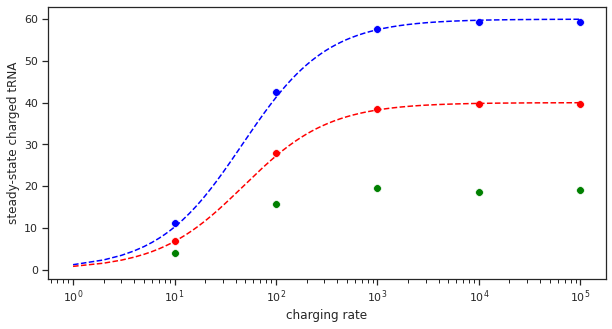

In [14]:
sns.set_theme(style="ticks", palette=None)
sns.scatterplot(data=TTT_only_eq, x="charging_rate", y="TTT_ss", s=60, color="blue")
sns.scatterplot(data=ATA_only_eq, x="charging_rate", y="ATA_ss", s=60, color="red")
sns.scatterplot(data=rib_only_eq, x="charging_rate", y="rib_ss", s=60, color="green")
plt.xscale("log")
plt.ylabel("steady-state charged tRNA")
plt.xlabel("charging rate")

x = np.arange(1, 100000, 1)
p = [analytical_trna(value, 60, 0.5) for value in x]
r = [analytical_trna(value, 40, 0.5) for value in x]

plt.plot(x, p, "b--")
plt.plot(x, r, "r--")

In [318]:
serializer = SerializeTwoCodonSingleTranscript(transcript_len=LEN,
                                                   codon_comp=(0.6, 0.4),
                                                   trna_proportion=(0.6, 0.4),
                                                   time_limit=500,
                                                   time_step=5)
serializer.serialize(f"../yaml/{date}")

In [16]:
df = pd.read_csv(f"../output/{date}/0.6_0.4_0.6_0.4_100000_codon_counts.tsv", sep="\t")

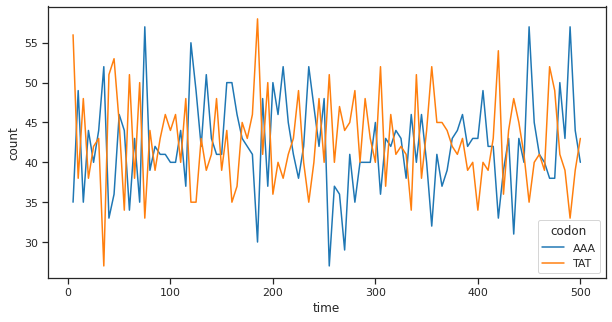

In [17]:
g = sns.lineplot(x="time", y="count", hue="codon", data=df)

In [18]:
df.groupby(["codon"]).mean()

,time,count
codon,,
AAA,252.499064,42.16
TAT,252.499064,42.65


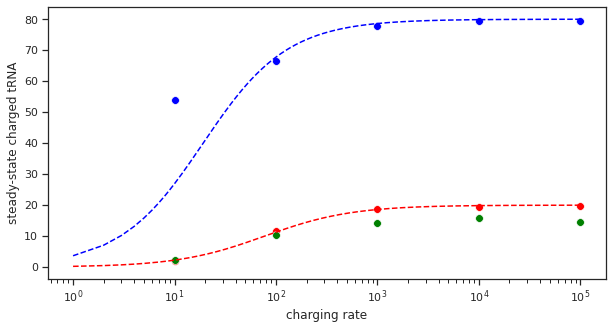

In [23]:
sns.set_theme(style="ticks", palette=None)
sns.scatterplot(data=TTT_only_more, x="charging_rate", y="TTT_ss", s=60, color="blue")
sns.scatterplot(data=ATA_only_more, x="charging_rate", y="ATA_ss", s=60, color="red")
sns.scatterplot(data=rib_only_more, x="charging_rate", y="rib_ss", s=60, color="green")
plt.xscale("log")
plt.ylabel("steady-state charged tRNA")
plt.xlabel("charging rate")

x = np.arange(1, 100000, 1)
p = [analytical_trna(value, 80, 0.21) for value in x]
r = [analytical_trna(value, 20, 0.79) for value in x]

plt.plot(x, p, "b--")
plt.plot(x, r, "r--")

In [326]:
serializer = SerializeTwoCodonSingleTranscript(transcript_len=LEN,
                                                   codon_comp=(0.6, 0.4),
                                                   trna_proportion=(0.8, 0.2),
                                                   time_limit=500,
                                                   time_step=5)
serializer.serialize(f"../yaml/{date}")

In [20]:
df = pd.read_csv(f"../output/{date}/0.6_0.4_0.8_0.2_100000_codon_counts.tsv", sep="\t")

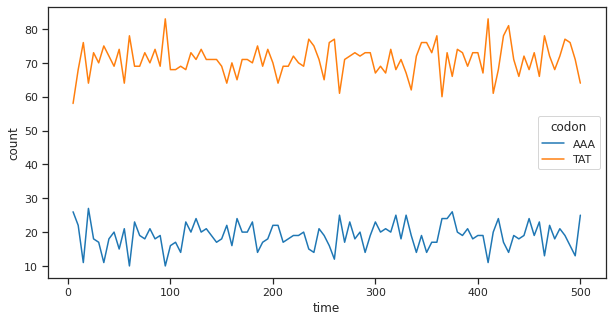

In [21]:
g = sns.lineplot(x="time", y="count", hue="codon", data=df)

In [22]:
df.groupby(["codon"]).mean()

,time,count
codon,,
AAA,252.499165,18.94
TAT,252.499165,70.82


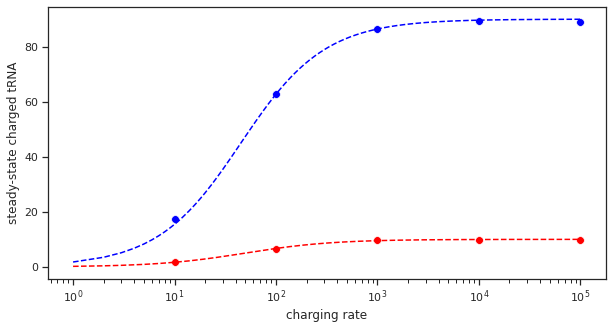

In [305]:
sns.set_theme(style="ticks", palette=None)
sns.scatterplot(data=TTT_only_less, x="charging_rate", y="TTT_ss", s=60, color="blue")
sns.scatterplot(data=ATA_only_less, x="charging_rate", y="ATA_ss", s=60, color="red")
#sns.scatterplot(data=rib_only_less, x="charging_rate", y="rib_ss", s=60, color="green")
plt.xscale("log")
plt.ylabel("steady-state charged tRNA")
plt.xlabel("charging rate")

x = np.arange(1, 100000, 1)
p = [analytical_trna(value, 90, 0.5) for value in x]
r = [analytical_trna(value, 10, 0.5) for value in x]

plt.plot(x, p, "b--")
plt.plot(x, r, "r--")

In [310]:
#!mkdir ../yaml/nov-20-2023

In [312]:
serializer = SerializeTwoCodonSingleTranscript(transcript_len=LEN,
                                                   codon_comp=(0.9, 0.1),
                                                   trna_proportion=(0.9, 0.1),
                                                   time_limit=500,
                                                   time_step=5)
serializer.serialize(f"../yaml/{date}")

In [314]:
df = pd.read_csv(f"../output/{date}/0.9_0.1_0.9_0.1_100000_codon_counts.tsv", sep="\t")

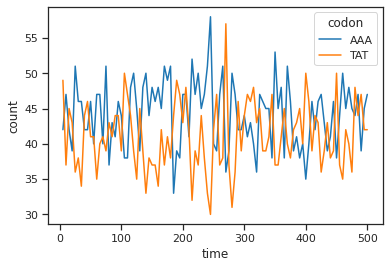

In [316]:
g = sns.lineplot(x="time", y="count", hue="codon", data=df)

In [317]:
df.groupby(["codon"]).mean()

,time,count
codon,,
AAA,252.499067,44.26
TAT,252.499067,41.19


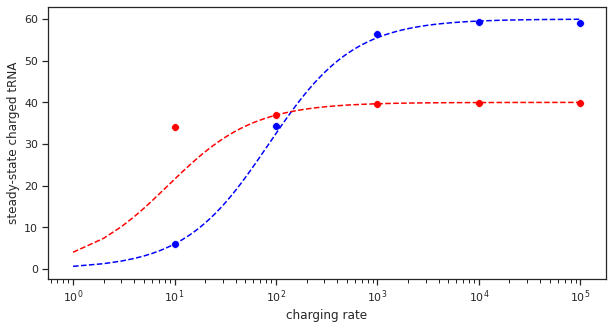

In [28]:
sns.set_theme(style="ticks", palette=None)
sns.scatterplot(data=TTT_only_l, x="charging_rate", y="TTT_ss", s=60, color="blue")
sns.scatterplot(data=ATA_only_l, x="charging_rate", y="ATA_ss", s=60, color="red")
#sns.scatterplot(data=rib_only_less, x="charging_rate", y="rib_ss", s=60, color="green")
plt.xscale("log")
plt.ylabel("steady-state charged tRNA")
plt.xlabel("charging rate")

x = np.arange(1, 100000, 1)
p = [analytical_trna(value, 60, 0.91) for value in x]
r = [analytical_trna(value, 40, 0.09) for value in x]

plt.plot(x, p, "b--")
plt.plot(x, r, "r--")

In [337]:
serializer = SerializeTwoCodonSingleTranscript(transcript_len=LEN,
                                                   codon_comp=(0.9, 0.1),
                                                   trna_proportion=(0.6, 0.4),
                                                   time_limit=500,
                                                   time_step=5)
serializer.serialize(f"../yaml/{date}")

In [25]:
df = pd.read_csv(f"../output/{date}/0.9_0.1_0.6_0.4_100000_codon_counts.tsv", sep="\t")

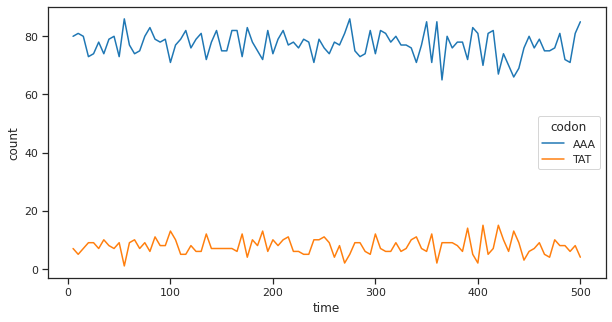

In [26]:
g = sns.lineplot(x="time", y="count", hue="codon", data=df)

In [27]:
df.groupby(["codon"]).mean()

,time,count
codon,,
AAA,252.499058,77.19
TAT,252.499058,7.76


In [109]:
date = "nov-27-2023"

In [115]:
codon_ratios = range(5, 100, 5)

In [39]:
LEN = 100
for i in codon_ratios:
    pref = i/100
    rare = (100-i)/100
    serializer = SerializeTwoCodonSingleTranscript(transcript_len=LEN,
                                                       codon_comp=(pref, rare),
                                                       trna_proportion=(0.6, 0.4),
                                                       time_limit=500,
                                                       time_step=5)
    serializer.serialize(f"../yaml/{date}")

In [123]:
configs = os.listdir(f"../yaml/{date}")
seeds = [1,2,3]
with open(f"../scripts/cmd_files/{date}-c.txt", "w") as stream:
    for config in configs:
        for seed in seeds:
            cmd = f"python3 twocodonsingletranscript.py ../yaml/{date}/{config} {seed} 100 100 100 100000.0 50.0 50.0 ../output/{date}-c"
            stream.write(cmd)
            stream.write("\n")

In [58]:
trna_06_04 = None
for i in codon_ratios:
    pref = i/100
    rare = (100-i)/100
    path = f"../output/{date}/two_codon_single_transcript_{pref}_{rare}_0.6_0.4_100_100_100_100000.0_100.0_100.0"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["pref_codon"] = pref
    trna_06_04 = tmp if trna_06_04 is None else trna_06_04.append(tmp, ignore_index=True)

In [116]:
trna_06_04_slow_chrg = None
for i in codon_ratios:
    pref = i/100
    rare = (100-i)/100
    path = f"../output/{date}-b/two_codon_single_transcript_{pref}_{rare}_0.6_0.4_100_100_100_100000.0_75.0_75.0"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["pref_codon"] = pref
    trna_06_04_slow_chrg = tmp if trna_06_04_slow_chrg is None else trna_06_04_slow_chrg.append(tmp, ignore_index=True)

In [124]:
trna_06_04_c = None
for i in codon_ratios:
    pref = i/100
    rare = (100-i)/100
    path = f"../output/{date}-c/two_codon_single_transcript_{pref}_{rare}_0.6_0.4_100_100_100_100000.0_50.0_50.0"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["pref_codon"] = pref
    trna_06_04_c = tmp if trna_06_04_c is None else trna_06_04_c.append(tmp, ignore_index=True)

In [60]:
species = ["ATA_charged", "TTT_charged", "ribosomes"]
trna_06_04_s = trna_06_04.loc[trna_06_04['species'].isin(species)]
trna_06_04_p = trna_06_04.loc[trna_06_04['species'].isin(["proteinX"])]

In [117]:
species = ["ATA_charged", "TTT_charged", "ribosomes"]
trna_06_04_slow_chrg_s = trna_06_04_slow_chrg.loc[trna_06_04_slow_chrg['species'].isin(species)]
trna_06_04_slow_chrg_p = trna_06_04_slow_chrg.loc[trna_06_04_slow_chrg['species'].isin(["proteinX"])]

In [125]:
species = ["ATA_charged", "TTT_charged", "ribosomes"]
trna_06_04_slow_c_s = trna_06_04_c.loc[trna_06_04_c['species'].isin(species)]
trna_06_04_slow_c_p = trna_06_04_c.loc[trna_06_04_c['species'].isin(["proteinX"])]

Text(0.5, 0, 'AAA usage')

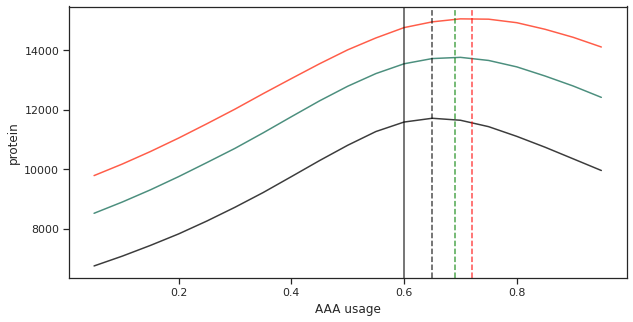

In [171]:
colors = ["#ff5d49", "#4c8f7e", "#3c3c3c"]
sns.set_palette(sns.color_palette(colors))

g = sns.lineplot(x="pref_codon", y="protein", data=trna_06_04_p)
g = sns.lineplot(x="pref_codon", y="protein", data=trna_06_04_slow_chrg_p)
g = sns.lineplot(x="pref_codon", y="protein", data=trna_06_04_slow_c_p)
plt.gca().axvline(0.72, ls='--', color="red", alpha=0.7)
plt.gca().axvline(0.69, ls='--', color="green", alpha=0.7)
plt.gca().axvline(0.65, ls='--', color="black", alpha=0.7)
plt.gca().axvline(0.6, ls='-', color="black", alpha=0.7)
plt.xlabel("AAA usage")

In [141]:
codon_ratios = range(5, 100, 5)
df1 = None
for i in codon_ratios:
    pref = i/100
    rare = (100-i)/100
    path = f"../output/{date}-c/two_codon_single_transcript_{pref}_{rare}_0.6_0.4_100_100_100_100000.0_50.0_50.0_1.tsv.codon"
    tmp = pd.read_csv(path, sep="\t")
    tmp = tmp.groupby(["codon"])["count"].mean().reset_index() 
    tmp["fraction_AAA"] = pref
    df1 = tmp if df1 is None else df1.append(tmp, ignore_index=True)
df1["charging rate"] = 50

In [142]:
codon_ratios = range(5, 100, 5)
df2 = None
for i in codon_ratios:
    pref = i/100
    rare = (100-i)/100
    path = f"../output/{date}/two_codon_single_transcript_{pref}_{rare}_0.6_0.4_100_100_100_100000.0_100.0_100.0_1.tsv.codon"
    tmp = pd.read_csv(path, sep="\t")
    tmp = tmp.groupby(["codon"])["count"].mean().reset_index() 
    tmp["fraction_AAA"] = pref
    df2 = tmp if df2 is None else df2.append(tmp, ignore_index=True)
df2["charging rate"] = 100

Text(0.5, 0, 'codon occupancy usage')

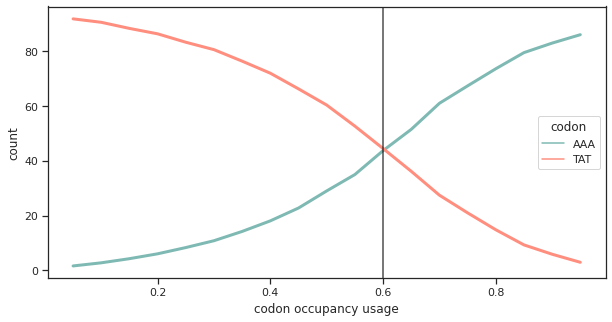

In [168]:
colors = ["#7fb9b3", "#ff8e7f"]
sns.set_palette(sns.color_palette(colors))
g = sns.lineplot(x="fraction_AAA", y="count", hue="codon", data=df1, linewidth=3)
plt.xlabel("AAA usage")
plt.gca().axvline(0.60, ls='-', color="black", alpha=0.7)
plt.xlabel("codon occupancy usage")

#colors = ["#ff5d49", "#4c8f7e", "#3c3c3c"]
#sns.set_palette(sns.color_palette(colors))
#g = sns.lineplot(x="pref_codon", y="protein", hue="species", data=trna_06_04_slow_c_s, linewidth=3)
#plt.gca().axvline(0.65, ls='-', color="black", alpha=0.5)
#plt.gca().axhline(60, ls='--', color="green", alpha=0.5)
#plt.gca().axhline(40, ls='--', color="red", alpha=0.5)

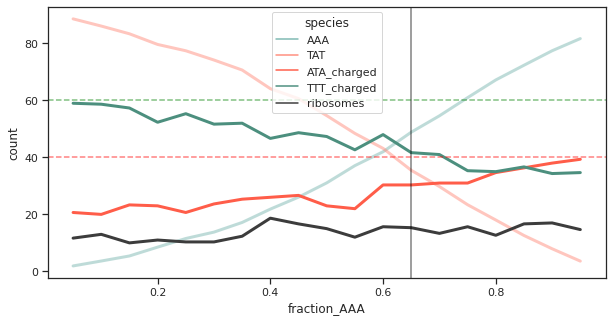

In [140]:
colors = ["#7fb9b3", "#ff8e7f"]
sns.set_palette(sns.color_palette(colors))
g = sns.lineplot(x="fraction_AAA", y="count", hue="codon", data=df2, linewidth=3, alpha=0.5)

colors = ["#ff5d49", "#4c8f7e", "#3c3c3c"]
sns.set_palette(sns.color_palette(colors))
g = sns.lineplot(x="pref_codon", y="protein", hue="species", data=trna_06_04_s, linewidth=3)
plt.gca().axvline(0.65, ls='-', color="black", alpha=0.5)
plt.gca().axhline(60, ls='--', color="green", alpha=0.5)
plt.gca().axhline(40, ls='--', color="red", alpha=0.5)

Text(0.5, 0, 'AAA usage')

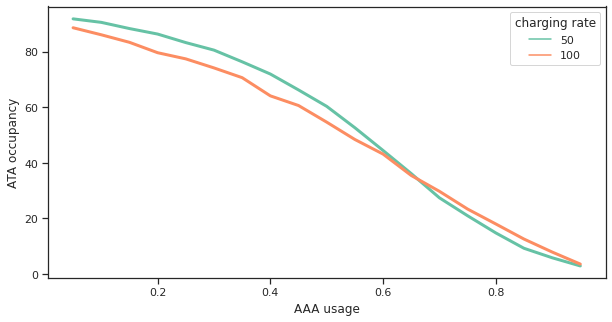

In [169]:
df_ap = pd.concat([df1, df2], ignore_index = True)
df_ap = df_app[(df_app.codon == "TAT")]
df_ap
g = sns.lineplot(x="fraction_AAA", y="count", hue="charging rate", data=df_ap, linewidth=3, palette="Set2")
plt.ylabel("ATA occupancy")
plt.xlabel("AAA usage")

In [89]:
date = "nov-28-2023"

In [102]:
LEN = 100
codon_ratios = range(2, 100, 2)
for i in codon_ratios:
    pref = i/100
    rare = (100-i)/100
    serializer = SerializeTwoCodonSingleTranscript(transcript_len=LEN,
                                                       codon_comp=(pref, rare),
                                                       trna_proportion=(0.9, 0.1),
                                                       time_limit=500,
                                                       time_step=5)
    serializer.serialize(f"../yaml/{date}")

In [94]:
configs = os.listdir(f"../yaml/{date}")
seeds = [1,2,3]
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for seed in seeds:
            cmd = f"python3 twocodonsingletranscript.py ../yaml/{date}/{config} {seed} 100 100 100 100000.0 100.0 100.0 ../output/{date}"
            stream.write(cmd)
            stream.write("\n")

In [95]:
trna_095_005 = None
for i in codon_ratios:
    pref = i/100
    rare = (100-i)/100
    path = f"../output/{date}/two_codon_single_transcript_{pref}_{rare}_0.95_0.05_100_100_100_100000.0_100.0_100.0"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["pref_codon"] = pref
    trna_095_005 = tmp if trna_095_005 is None else trna_095_005.append(tmp, ignore_index=True)

In [96]:
species = ["ATA_charged", "TTT_charged", "ribosomes"]
trna_095_005_s = trna_095_005.loc[trna_095_005['species'].isin(species)]
trna_095_005_p = trna_095_005.loc[trna_095_005['species'].isin(["proteinX"])]

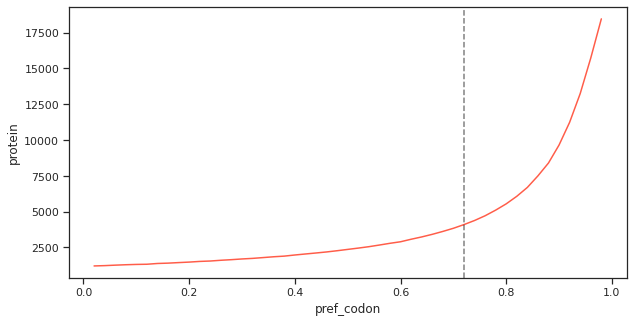

In [97]:
g = sns.lineplot(x="pref_codon", y="protein", data=trna_095_005_p)
plt.gca().axvline(0.72, ls='--', color="black", alpha=0.5)

In [98]:
df = None
for i in codon_ratios:
    pref = i/100
    rare = (100-i)/100
    path = f"../output/{date}/two_codon_single_transcript_{pref}_{rare}_0.95_0.05_100_100_100_100000.0_100.0_100.0_1.tsv.codon"
    tmp = pd.read_csv(path, sep="\t")
    tmp = tmp.groupby(["codon"])["count"].mean().reset_index() 
    tmp["fraction_AAA"] = pref
    df = tmp if df is None else df.append(tmp, ignore_index=True)

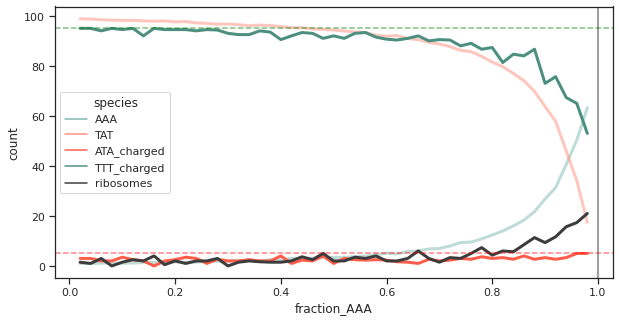

In [101]:
colors = ["#7fb9b3", "#ff8e7f"]
sns.set_palette(sns.color_palette(colors))
g = sns.lineplot(x="fraction_AAA", y="count", hue="codon", data=df, linewidth=3, alpha=0.5)

colors = ["#ff5d49", "#4c8f7e", "#3c3c3c"]
sns.set_palette(sns.color_palette(colors))
g = sns.lineplot(x="pref_codon", y="protein", hue="species", data=trna_095_005_s, linewidth=3)
plt.gca().axvline(1, ls='-', color="black", alpha=0.5)
plt.gca().axhline(95, ls='--', color="green", alpha=0.5)
plt.gca().axhline(5, ls='--', color="red", alpha=0.5)

In [103]:
date = "nov-28-2023-b"

In [104]:
LEN = 100
codon_ratios = range(2, 100, 2)
for i in codon_ratios:
    pref = i/100
    rare = (100-i)/100
    serializer = SerializeTwoCodonSingleTranscript(transcript_len=LEN,
                                                       codon_comp=(pref, rare),
                                                       trna_proportion=(0.9, 0.1),
                                                       time_limit=500,
                                                       time_step=5)
    serializer.serialize(f"../yaml/{date}")

In [105]:
configs = os.listdir(f"../yaml/{date}")
seeds = [1,2,3]
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for seed in seeds:
            cmd = f"python3 twocodonsingletranscript.py ../yaml/{date}/{config} {seed} 100 100 100 100000.0 100.0 100.0 ../output/{date}"
            stream.write(cmd)
            stream.write("\n")

In [106]:
trna_09_01 = None
for i in codon_ratios:
    pref = i/100
    rare = (100-i)/100
    path = f"../output/{date}/two_codon_single_transcript_{pref}_{rare}_0.9_0.1_100_100_100_100000.0_100.0_100.0"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["pref_codon"] = pref
    trna_09_01 = tmp if trna_09_01 is None else trna_09_01.append(tmp, ignore_index=True)

In [107]:
species = ["ATA_charged", "TTT_charged", "ribosomes"]
trna_09_01_s = trna_09_01.loc[trna_09_01['species'].isin(species)]
trna_09_01_p = trna_09_01.loc[trna_09_01['species'].isin(["proteinX"])]

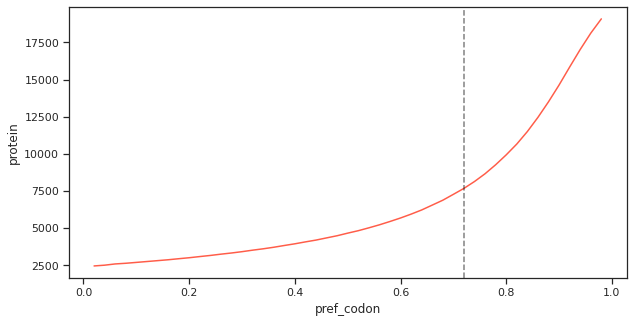

In [108]:
g = sns.lineplot(x="pref_codon", y="protein", data=trna_09_01_p)
plt.gca().axvline(0.72, ls='--', color="black", alpha=0.5)